# Model Training and Test-Set Predictions

**Multi-label audio classification using fastai2 on a GCP AI notebook instance**

**fastai2_audio**

The additional requirements of the fastai2_audio package will be dealt with below, using a clone of the following repo:

https://github.com/rbracco/fastai2_audio

## Install fastai2 base package

In [40]:
#Run once per session
#In Colab we need to run this as a notebook command )i.e. no '!' infront of 'pip'
#This is in comparison to shell commands i.e. with '!' infront of 'pip'
!pip install fastai2

**Download Dataset**

The dataset will be downloaded directly from Kaggle using the steps outlined within the following Kaggle Forum post:

https://www.kaggle.com/general/74235

In [ ]:
# Install kaggle
!pip install -q kaggle

Now upload kaggle.json  API file before running next cell:

In [ ]:
# Make a directory for the json and choose the JSON file
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
 # copy JSON file
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset

! kaggle competitions download -c 'freesound-audio-tagging-2019' -p '../data/'

In [ ]:
!unzip -d ../data/ ../data/freesound-audio-tagging-2019.zip  # Unzip main data folder

In [ ]:
!unzip -d ../data/train_curated ../data/train_curated.zip; # Unzip train curated folder

In [ ]:
!unzip -d ../data/train_noisy ../data/train_noisy.zip; # Unzip train noisy folder

In [ ]:
!unzip -d ../data/test ../data/test.zip; # Unzip test folder

In [ ]:
import os
files = os.listdir('../data/train_curated')
len(files)

In [ ]:
files = os.listdir('../data/train_noisy')
len(files)

## Install the fastai2_audio library

We need to install the fastai2_audio library to the local kernel/environment for the analysis

In [41]:
#In Colab we would run this as a shell command i.e. with '!' infront of 'pip'

!pip install git+https://github.com/rbracco/fastai2_audio.git

  Cloning https://github.com/rbracco/fastai2_audio.git to /tmp/pip-req-build-t8lrb1xe
  Running command git clone -q https://github.com/rbracco/fastai2_audio.git /tmp/pip-req-build-t8lrb1xe
  Created wheel for fastai2-audio: filename=fastai2_audio-0.0.1-py3-none-any.whl size=15737 sha256=d93b980328a0d25e40b155552b1e200dfce06b366f84341c0b796eb4cd0fa2ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-hb0jegyl/wheels/df/0a/98/dff9668a725473b00cd6fe866c0a4a2cafa88447bf6850df60
Successfully built fastai2-audio


In [42]:
# Solving an OSError problem with Librosa SoundFile dependency (libsndfile)
# SageMaker/GCP Only

!conda install -c conda-forge libsndfile --yes

Solving environment: done

# All requested packages already installed.



# Create the Datasets and view possible Augmentations

The audio package analysis follows guidance given within the above fastai2_audio repo and the following additional repo: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Audio.ipynb

In [1]:
from fastai2.vision.all import *
from fastai2_audio.core import *
from fastai2_audio.augment import *

**Create Dataframes from csv files**

**Note: Delete Corrupted and empty files list in Kaggle Competition Note**

*The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process: f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav*

*The audio file 1d44b0bd.wav in the curated train set was found to be corrupted (contains no signal) due to an error in format conversion.*

In [2]:
# Create train Dataframes

def create_train_curated_df(file, remove_files=[]):
    df_curated = pd.read_csv(file)
    df_curated['fname'] = '../data/train_curated/' + df_curated['fname'] 
    df_curated.set_index('fname', inplace=True)
    df_curated.loc[remove_files]
    df_curated.drop(index=remove_files, inplace=True)
    df_curated.reset_index(inplace=True)
    return df_curated

def create_train_noisy_df(file):
    df_noisy = pd.read_csv(file)
    df_noisy['fname'] = '../data/train_noisy/' + df_noisy['fname'] 
    return df_noisy

In [3]:
# Create Curated training set df

# Remove corrupt and empty files as per Kaggle

remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
remove_files = ['../data/train_curated/' + i for i in remove_files]
df_curated = create_train_curated_df('../data/train_curated.csv', remove_files=remove_files)
df_curated.head()

,fname,labels
0,../data/train_curated/0006ae4e.wav,Bark
1,../data/train_curated/0019ef41.wav,Raindrop
2,../data/train_curated/001ec0ad.wav,Finger_snapping
3,../data/train_curated/0026c7cb.wav,Run
4,../data/train_curated/0026f116.wav,Finger_snapping


In [4]:
df_curated.describe()

,fname,labels
count,4964,4964
unique,4964,213
top,../data/train_curated/cfce6a28.wav,Gong
freq,1,75


In [5]:
# Create train_noise Dataframe
df_noisy = create_train_noisy_df('../data/train_noisy.csv')
df_noisy.head()

,fname,labels
0,../data/train_noisy/00097e21.wav,Bathtub_(filling_or_washing)
1,../data/train_noisy/000b6cfb.wav,Motorcycle
2,../data/train_noisy/00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,../data/train_noisy/00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,../data/train_noisy/0019adae.wav,Raindrop


In [6]:
df_noisy.describe()

,fname,labels
count,19815,19815
unique,19815,1168
top,../data/train_noisy/e37a8a02.wav,Waves_and_surf
freq,1,291


## Using the DataBlock API:

* We will define our audio data transforms and augmentations to be used
* Define the  "getter" to get retrieve the files using the DataFrame
* Define the  "labeller" to get retrieve the file labels using the DataFrame

The following datablock method references the new and wonderful **"Fastbook"** by fastai:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the above mentioned Audio notebook by Z Mueller.

> ### Constructing a data block
>
>How do we convert from a DataFrame object to a DataLoaders object? PyTorch and fastai have two main classes for representing and accessing a training set or validation set:
>
>* **Dataset**:: a collection which returns a tuple of your independent and dependent variable for a single item
>* **DataLoader**:: an iterator which provides a stream of mini batches, where each mini batch is a couple of a batch of independent variables and a batch of dependent variables
>
>On top of these, fastai provides two classes for bringing your training and validation sets together:
>
>* **Datasets**:: an object which contains a training Dataset and a validation Dataset
>* **DataLoaders**:: an object which contains a training DataLoader and a validation DataLoader
>
>Since a DataLoader builds on top of a Dataset, and adds additional functionality to it (collating multiple items into a mini batch), it’s often easiest to start by creating and testing Datasets, and then look at DataLoaders after that’s working.


The files in this case have multi-labels within the 'labels' column of the dataframe. 

So we will need to set the multi-labels appropriately in training.

First, we can view the augmentations and settings before applying them in the training loops below.

## Data Augmentation

The fastai2 audio `SpectrogramTransformer` class will be used to define the transforms that will open the audio file and convert the data to mel-spectrogram tensors that can be fed into the CNN.

In [12]:
def get_x(r): return r['fname']
def get_y(r): return r['labels'].split(',') # split labels on ','
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df_combined)
dsets.train[0]

('../data/train_noisy/6f9a43ad.wav', ['Clapping'])

In [13]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

We can see the default settings - described in greater detail below:

In [14]:
cfg = AudioConfig.BasicMelSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 16000,
 'n_fft': 400,
 'win_length': 400,
 'hop_length': 200,
 'f_min': 0.0,
 'f_max': None,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': None}

In [15]:
# Now let's change the settings to see the impact
aud2spec = DBMelSpec(sample_rate= 16000, f_max=None, f_min=20, n_mels=128, n_fft=1024, hop_length=128, top_db=90)
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 128,
 'f_min': 20,
 'f_max': None,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': 90}

For our transforms, we'll use:
* `RemoveSilence` - This splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal` - Crops a signal by `duration` and adds padding if needed
* `aud2spec` - Our `SpectrogramTransformer` with parameters
* `MaskTime` - Wrapper for Google SpecAugment time masking feature [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)
* `MaskFreq` - Applies Google SpecAugment frequency masking feature

In [16]:
item_tfms = [RemoveSilence(), CropSignal(3000, pad_mode='Repeat'), aud2spec, MaskTime(num_masks=1, size=100), MaskFreq(num_masks=1, size=10)]

The following DataBlock combines the requiored `AudioBlock` for the audio transforms and the `MultiCategoryBlock` for multi-label classification. This type of block expects to receive a list of strings for the different labels.

In [17]:
dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSplitter(),
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = item_tfms)

# dsets = dblock.datasets(df_curated)
dsets = dblock.datasets(df_combined)
dsets.train[0]

(AudioTensor([[0.0048, 0.0059, 0.0083,  ..., 0.0992, 0.0555, 0.0686]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [18]:
# Let's see what size the training and validation dataset items have

xt,yt = dsets.train[0] # xt = AudioTensor, yt = TensorMultiCategory
xt.shape,yt.shape,len(dsets.train) # show shapes and dataset size (no. items)

(torch.Size([1, 661500]), torch.Size([80]), 19824)

In [19]:
xv,yv = dsets.valid[0]
xv.shape,yv.shape,len(dsets.valid)

(torch.Size([1, 661500]), torch.Size([80]), 4955)

In the above we can see the created audiotensor and the one-hot encoded labels: TensorMultiCategory.

Let’s check what the categories represent for this example (we are using the convenient torch.where function, which tells us all of the indices where our condition is true or false).

In [20]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['Fart']

**Now we define our DataLoader**

>A `DataLoader` collates the items from a `Dataset` into a mini batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item.

In [21]:
dls = dblock.dataloaders(df_combined, bs=32) # bs= batch_size
x,y = dls.one_batch()
x.mean(),x.std()

(AudioSpectrogram(-17.7887, device='cuda:0'),
 AudioSpectrogram(22.1577, device='cuda:0'))

In [22]:
# Let's check our batch shape
dls.one_batch()[0].shape

torch.Size([32, 1, 128, 1034])

Now we can finally view the produced mel-spectrograms:

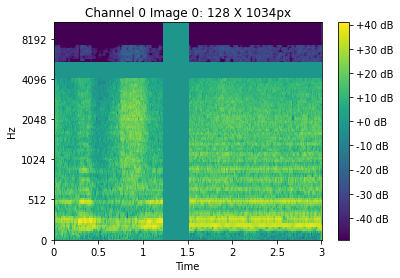

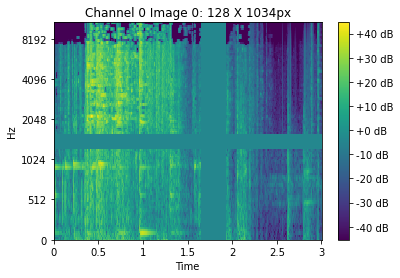

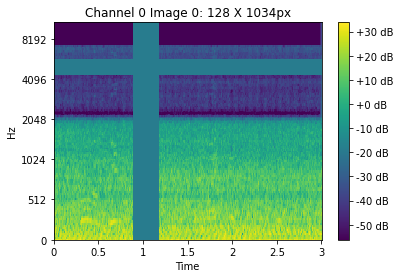

Hiss
Shatter
Microwave_oven


In [23]:
dls.show_batch(max_n=3)

# Staged Training Approach

1. Stage 1 - Train on Noisy Train Set using 5-Folds Cross Validation
2. Stage 2 - Train on Curated Train Set using 5-Folds Cross Validation
3. Stage 3 - Ensemble the 5 Stage-2 Model's predictions (averaging) on Test test set. Submit to kaggle to see results.

**Note on Multi-category Loss Function**

Fastbook:

>Normally for one-hot encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross entropy in a single function, as in our example above.

In this case, we're going to use BCEWithLogitsLossFlat():

```"Same as `nn.CrossEntropyLoss`, but flattens input and target."```

Also, we change the output to be 80 neurons to match the labels.

## Using an LWL-wrap Metric

For the Kaggle competition the metric used was lwl wrap:

_The primary competition metric will be label-weighted label-ranking average precision (lwlrap, pronounced "Lol wrap"). This measures the average precision of retrieving a ranked list of relevant labels for each test clip (i.e., the system ranks all the available labels, then the precisions of the ranked lists down to each true label are averaged). This is a generalization of the mean reciprocal rank measure (used in last year’s edition of the competition) for the case where there can be multiple true labels per test item. The novel "label-weighted" part means that the overall score is the average over all the labels in the test set, where each label receives equal weight (by contrast, plain lrap gives each test item equal weight, thereby discounting the contribution of individual labels when they appear on the same item as multiple other labels)._

_We use label weighting because it allows per-class values to be calculated, and still have the overall metric be expressed as simple average of the per-class metrics (weighted by each label's prior in the test set). For participant’s convenience, a Python implementation of lwlrap is provided in [this](https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8) public Google Colab._

An implementation for fastai is also outlined within this competition kernel, used below:

https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai

In [24]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

## Stage 1 - Train on Noisy Set

First we need to define the Mel-Spectrogram transform settings:

In [25]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

In [26]:
clip_length = 2 # clip subsection length in seconds
sr = 44100 # sample rate
f_min = 20 # mel-spectrogram minimum frequency
f_max = 20000 # mel-spectrogram minimum frequency
n_mels = 128 # mel-frequency bins
hop_length = math.ceil((clip_length*sr)/n_mels)# determines width of image. for square to match n_mels, set math.ceil((clip_length*sr)/n_mels)
nfft = n_mels * 20 # = 2560 for higher resolution in y-axis
win_length = 1024 # sample windowing
top_db = 60 # highest noise level in relative db

In [27]:
cfg = AudioConfig.BasicMelSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
aud2spec = DBMelSpec(sample_rate=sr, win_length=win_length, f_max=f_max, f_min=f_min, n_mels=n_mels, n_fft=nfft, hop_length=hop_length, top_db=top_db)
aud2spec.settings

{'mel': True,
 'to_db': True,
 'sample_rate': 44100,
 'n_fft': 2560,
 'win_length': 1024,
 'hop_length': 690,
 'f_min': 20,
 'f_max': 20000,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': 60}

In [28]:
item_tfms = [RemoveSilence(threshold=20), 
             CropSignal(clip_length*1000), 
             aud2spec, 
             MaskTime(num_masks=1, size=8), MaskFreq(num_masks=1, size=8)]

## 5-Fold Noisy Train


The basic method followed for acheiving the K-Folds is outlined within the following two repos: 

* https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/63f3a652d7d0267d3f417c8d76817d9ddcdea2dd/Computer%20Vision/03_Cross_Validation.ipynb


* https://github.com/ebouteillon/freesound-audio-tagging-2019/blob/master/code/training-cnn-model1.ipynb

In [30]:
from sklearn.model_selection import KFold

In [31]:
# Declare Number Folds 
n_splits = 5

kf = KFold(n_splits=n_splits, random_state=42, shuffle=True) # random_state for repeatable results, shuffle indices

**Bag of Tricks xresnet50 also incorporating:**

* Mish activation fucntion
* Self Attention
* MaxblurPool
* Ranger optimization function

In [32]:
pip install kornia

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

In the training loop below, we first do use the RatioResize() method within the first 10 epoch training stage, then we use it in the second stage to allow for some training as a form of progressive retraining.


Noisy Train Set - Fold 1/5


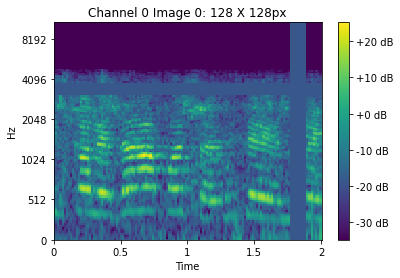

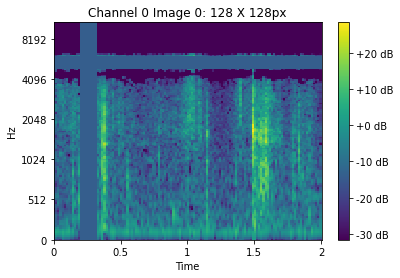

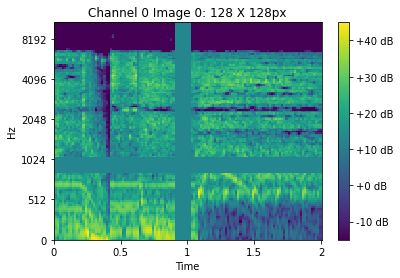

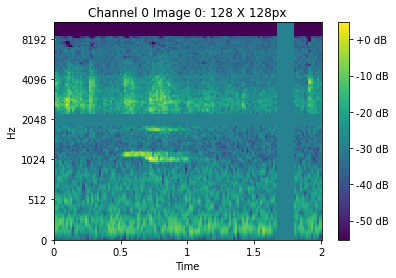

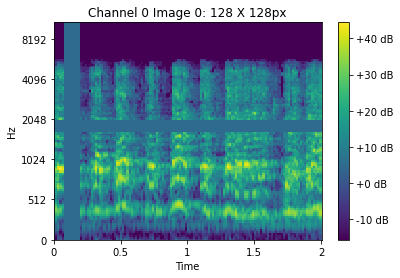

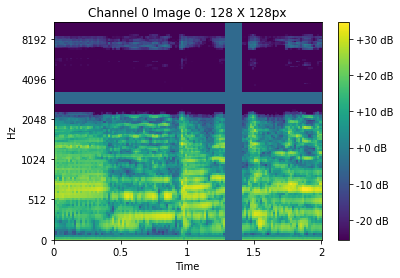

Crackle
Shatter
Shatter
Cupboard_open_or_close
Bathtub_(filling_or_washing)
Accordion


epoch,train_loss,valid_loss,lwlrap,time
0,0.066736,0.063693,0.313292,03:37
1,0.060416,0.060597,0.363720,04:08
2,0.056259,0.059023,0.386715,04:08
3,0.054893,0.057535,0.414336,04:08
4,0.052676,0.057007,0.428330,04:08
5,0.051379,0.052863,0.469963,04:08
6,0.050249,0.052088,0.484807,04:08
7,0.048711,0.052444,0.489394,04:08
8,0.046186,0.049699,0.516522,04:08
9,0.042653,0.048421,0.533706,04:08


Batch transforming images to 256x256px and training further.


epoch,train_loss,valid_loss,lwlrap,time
0,0.043979,0.049488,0.522869,04:04
1,0.043576,0.048764,0.529026,04:08
2,0.042172,0.048006,0.541508,04:08
3,0.042199,0.048830,0.530253,04:08
4,0.041785,0.048253,0.541367,04:08
5,0.040621,0.048592,0.542184,04:08
6,0.040763,0.049323,0.530844,04:07
7,0.039651,0.048324,0.542926,04:08
8,0.038087,0.047850,0.551722,04:08
9,0.036065,0.047872,0.551699,04:08


Saving Learner...

Noisy Train Set - Fold 2/5


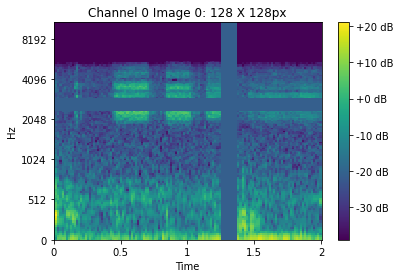

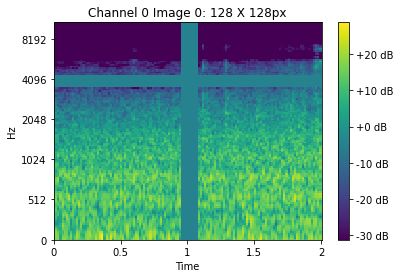

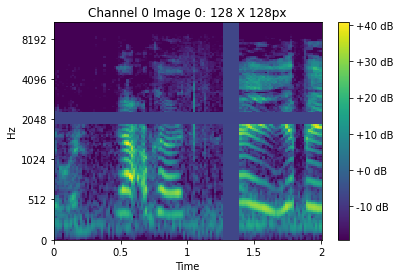

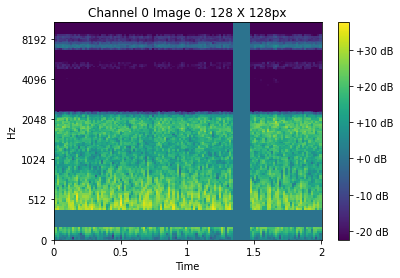

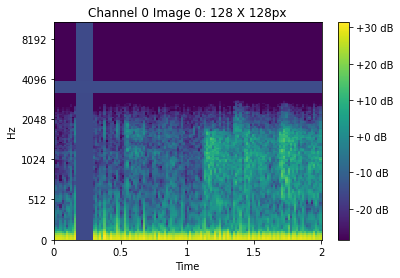

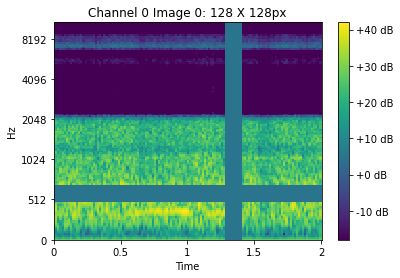

Writing
Bus
Keys_jangling;Whispering
Knock
Buzz
Slam


epoch,train_loss,valid_loss,lwlrap,time
0,0.067762,0.064435,0.300827,03:43
1,0.060860,0.059402,0.379837,04:08
2,0.057227,0.062447,0.360176,04:08
3,0.054971,0.061198,0.381043,04:08
4,0.053161,0.054509,0.455706,04:08
5,0.051615,0.051639,0.495040,04:08
6,0.050187,0.051384,0.493432,04:08
7,0.049374,0.050769,0.505553,04:07
8,0.047107,0.048950,0.534723,04:08
9,0.043711,0.046498,0.560166,04:08


Batch transforming images to 256x256px and training further.


epoch,train_loss,valid_loss,lwlrap,time
0,0.044458,0.047371,0.552202,04:04
1,0.044033,0.047163,0.558311,04:08
2,0.043047,0.047623,0.552444,04:08
3,0.042561,0.047603,0.550416,04:08
4,0.042568,0.046739,0.562858,04:08
5,0.041635,0.048101,0.545004,04:08
6,0.040266,0.047964,0.549751,04:08
7,0.040129,0.046608,0.560940,04:08
8,0.038372,0.046178,0.571691,04:08
9,0.036785,0.045516,0.573488,04:08


Saving Learner...

Noisy Train Set - Fold 3/5


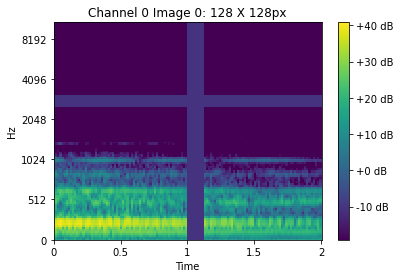

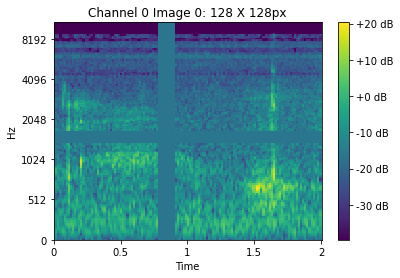

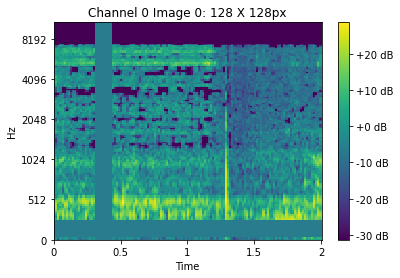

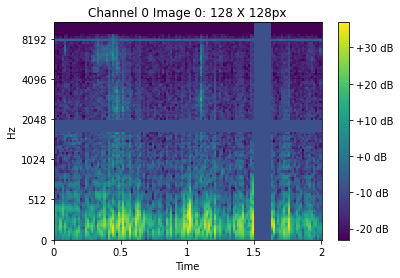

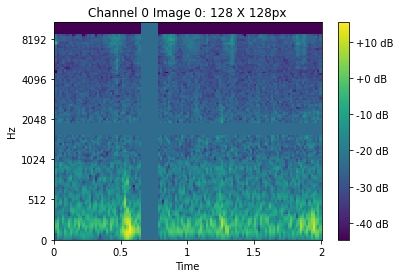

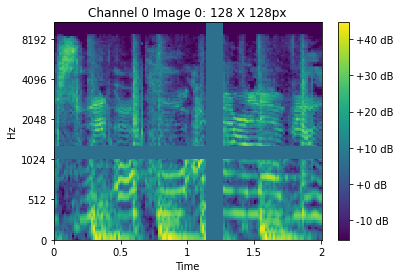

Gong
Chewing_and_mastication;Whispering
Fill_(with_liquid);Toilet_flush
Walk_and_footsteps
Keys_jangling
Finger_snapping


epoch,train_loss,valid_loss,lwlrap,time
0,0.067223,0.064324,0.307364,03:45
1,0.060396,0.062699,0.347667,04:08
2,0.057209,0.062774,0.346660,04:08
3,0.055371,0.060108,0.378781,04:09
4,0.053587,0.059531,0.404899,04:09
5,0.052219,0.052889,0.470945,04:08
6,0.050222,0.051765,0.495876,04:08
7,0.049232,0.051670,0.493178,04:07
8,0.046882,0.048911,0.533699,04:08
9,0.043456,0.047915,0.546537,04:08


Batch transforming images to 256x256px and training further.


epoch,train_loss,valid_loss,lwlrap,time
0,0.044691,0.048580,0.542929,04:04
1,0.043762,0.047965,0.543791,04:08
2,0.043544,0.048436,0.533859,04:08
3,0.042357,0.048314,0.539846,04:09
4,0.042234,0.048296,0.545318,04:08
5,0.041703,0.048935,0.547060,04:08
6,0.040877,0.048768,0.537840,04:08
7,0.039976,0.047823,0.554360,04:08
8,0.038408,0.047306,0.561386,04:08
9,0.036474,0.046772,0.561539,04:08


Saving Learner...

Noisy Train Set - Fold 4/5


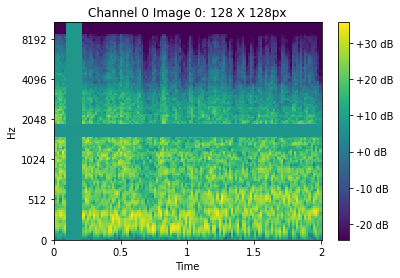

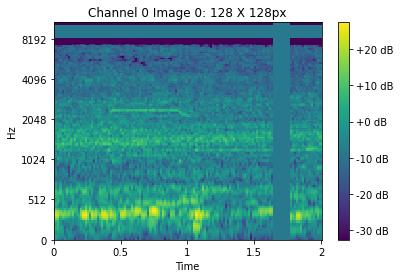

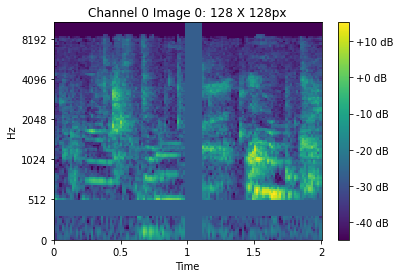

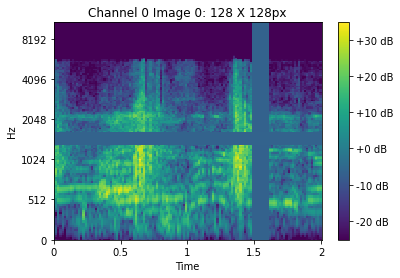

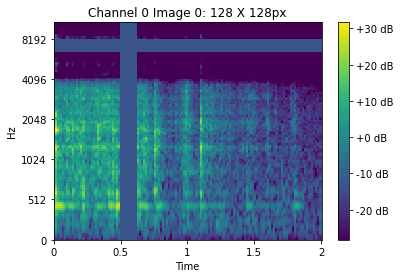

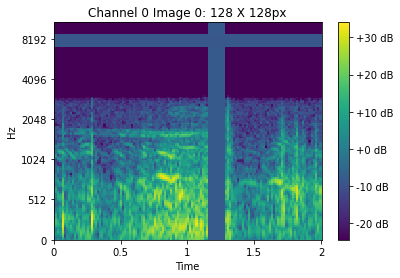

Car_passing_by;Race_car_and_auto_racing
Computer_keyboard;Knock;Scissors;Sink_(filling_or_washing)
Bathtub_(filling_or_washing)
Male_singing
Frying_(food)
Run


epoch,train_loss,valid_loss,lwlrap,time
0,0.067116,0.062807,0.314047,03:44
1,0.060561,0.060127,0.375865,04:08
2,0.057093,0.059693,0.375561,04:08
3,0.054321,0.057878,0.409692,04:08
4,0.053263,0.054661,0.442725,04:08
5,0.051335,0.052035,0.474353,04:08
6,0.049925,0.050097,0.501713,04:08
7,0.049265,0.050489,0.500548,04:08
8,0.046698,0.048438,0.523038,04:08
9,0.043491,0.046850,0.548313,04:08


Batch transforming images to 256x256px and training further.


epoch,train_loss,valid_loss,lwlrap,time
0,0.043804,0.047494,0.540496,04:04
1,0.043543,0.047485,0.544947,04:08
2,0.042873,0.047752,0.545882,04:08
3,0.042502,0.046898,0.551080,04:08
4,0.042068,0.047373,0.549522,04:08
5,0.041034,0.047528,0.548075,04:08
6,0.040574,0.047629,0.551620,04:08
7,0.039850,0.046777,0.559777,04:08
8,0.038458,0.045965,0.563806,04:08
9,0.035896,0.045773,0.569206,04:08


Saving Learner...

Noisy Train Set - Fold 5/5


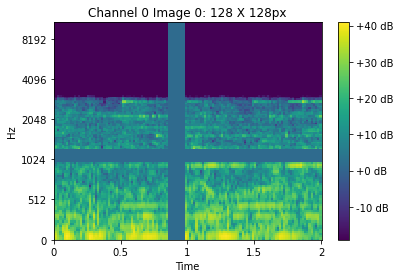

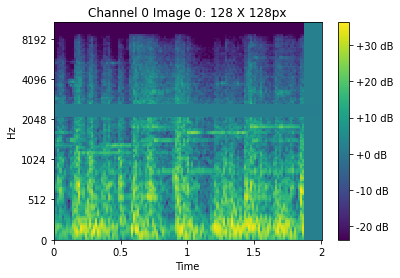

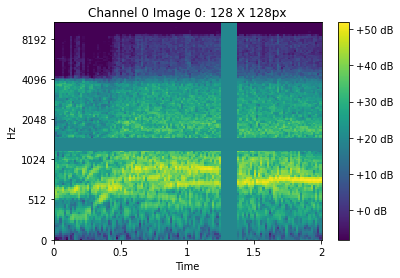

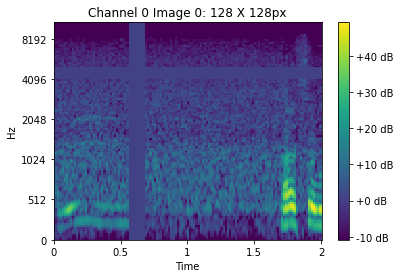

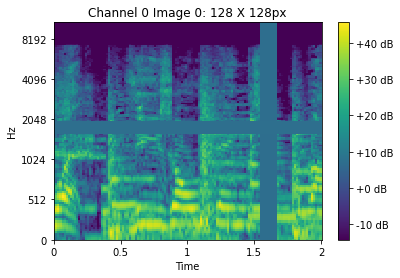

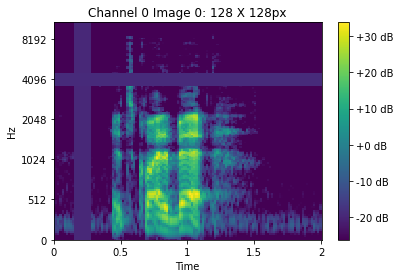

Glockenspiel
Glockenspiel;Marimba_and_xylophone
Crowd
Stream
Knock
Gasp


epoch,train_loss,valid_loss,lwlrap,time
0,0.066829,0.064106,0.316353,03:44
1,0.059656,0.061968,0.361160,04:08
2,0.056670,0.060364,0.383960,04:08
3,0.054600,0.058628,0.410388,04:08
4,0.053029,0.059868,0.405817,04:08
5,0.050833,0.052167,0.494479,04:08
6,0.049979,0.052318,0.501759,04:08
7,0.048860,0.052257,0.496477,04:08
8,0.046421,0.049318,0.536019,04:08
9,0.042883,0.047583,0.552996,04:08


Batch transforming images to 256x256px and training further.


epoch,train_loss,valid_loss,lwlrap,time
0,0.044384,0.049724,0.531109,04:04
1,0.043396,0.048213,0.549630,04:08
2,0.042895,0.048844,0.542785,04:08
3,0.041941,0.048664,0.548122,04:08


In [ ]:
df = df_noisy # to use random subset, use  df = df_.sample(frac=0.5, replace=False, random_state=1) # take random subset of the noisy dataframe for faster training (otherwise need 6.5 hours for all folds with complete dataset)

for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
    print(f'\nNoisy Train Set - Fold {fold+1}/{n_splits}')

    def get_x(r): return r['fname']
    def get_y(r): return r['labels'].split(',') # split labels on ','
        
    def get_dls(train_cycle):
        if train_cycle == 1:
            batch_tfms = [Normalize(),
                          Brightness(max_lighting=0.2, p=0.75),
                          Contrast(max_lighting=0.2, p=0.75)]
            
        elif train_cycle == 2:
            batch_tfms = [Normalize(),
                          RatioResize(256), # progressive resize to 256x256px
                          Brightness(max_lighting=0.2, p=0.75),
                          Contrast(max_lighting=0.2, p=0.75)]
        
        dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                           splitter=IndexSplitter(valid_idx), # split using df index
                           get_x=get_x,
                           get_y=get_y,
                           item_tfms = item_tfms,
                           batch_tfms = batch_tfms
                          )
        return dblock.dataloaders(df, bs=64)
    
    dls = get_dls(train_cycle=1)

    dls.show_batch(max_n=6)

    model = xresnet50(pretrained=False, act_cls=Mish, sa=True, c_in=1, n_out=80) #create custom xresnet: 1 input channel,  80 output nodes, self-attention, Mish activation function
    model = convert_MP_to_blurMP(model, nn.MaxPool2d) # convert MaxPool2D layers to MaxBlurPool
    learn = Learner(dls, model=model, loss_func=BCEWithLogitsLossFlat(), opt_func = ranger, metrics=[lwlrap]) # pass custom model to Learner, no mixup for noisy set as fewer epochs

    learn.fit_flat_cos(10, lr=3e-3)
    
    print('Batch transforming images to 256x256px and training further.')
    
    dls = get_dls(train_cycle=2)
    learn.dls = dls
    learn.fit_flat_cos(10, lr=3e-3/3)

    print('Saving Learner...')
    learn.save(f'stage-1_noisy_fold-{fold+1}_sota2')

## Stage 2 - K-Folds Cross-Validation on Curated Train Set

Train the 5 models again on different folds of the Curated Train Set, in order to provide 5 models trained on completely different datasets for later ensembling of predictions.

In [34]:
# Scale up images to 256x256px for progressive resizing on Curated Set

batch_tfms = [Normalize(),
              RatioResize(256),
              Brightness(max_lighting=0.2, p=0.75),
              Contrast(max_lighting=0.2, p=0.75)]


Curated Train Set - Fold 1/5


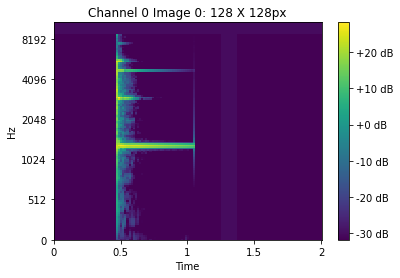

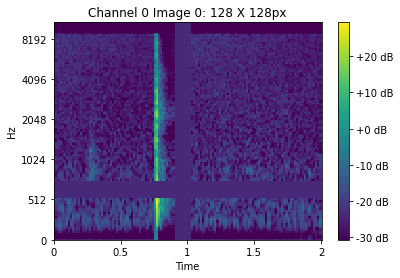

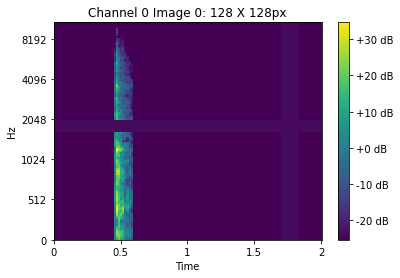

Glockenspiel
Clapping
Tap

Loading Stage 1 model - fold 1.

Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.060884,0.047488,0.550560,00:26
1,0.053138,0.041257,0.626818,00:22
2,0.049284,0.038339,0.663175,00:23
3,0.046731,0.036224,0.688877,00:23
4,0.044872,0.034793,0.713506,00:23
5,0.043481,0.033269,0.722158,00:23
6,0.042290,0.032727,0.730031,00:23
7,0.040793,0.032279,0.730625,00:23
8,0.040207,0.031097,0.744569,00:23
9,0.038905,0.031006,0.745333,00:23


Saving model...

Curated Train Set - Fold 2/5


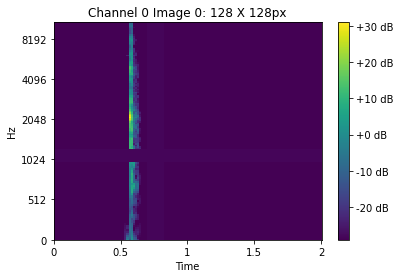

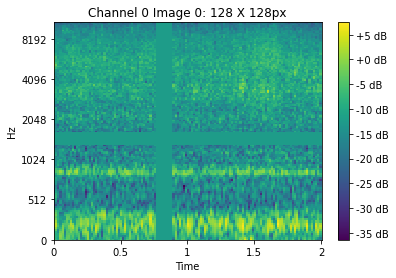

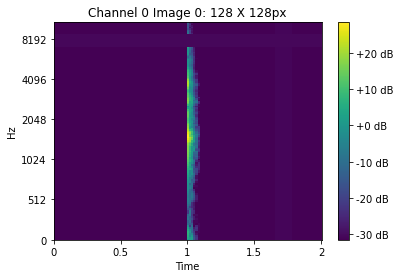

Drip;Raindrop
Frying_(food)
Finger_snapping

Loading Stage 1 model - fold 2.

Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.061296,0.048046,0.532741,00:23
1,0.053751,0.041455,0.618743,00:23
2,0.049601,0.038400,0.664368,00:23
3,0.047025,0.036888,0.683154,00:23
4,0.045022,0.034753,0.702925,00:23
5,0.043522,0.033740,0.710837,00:23
6,0.042012,0.032979,0.721845,00:23
7,0.040749,0.032197,0.726137,00:23
8,0.039559,0.030998,0.750265,00:23
9,0.039034,0.030716,0.747989,00:23


Saving model...

Curated Train Set - Fold 3/5


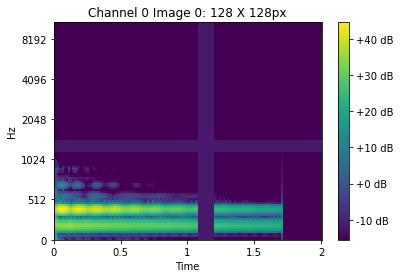

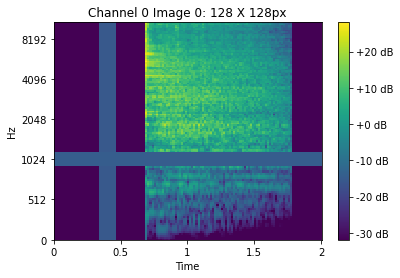

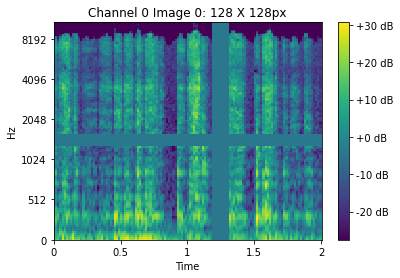

Gong
Hi-hat
Writing

Loading Stage 1 model - fold 3.

Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.061804,0.047496,0.531008,00:24
1,0.054022,0.041273,0.613670,00:24
2,0.049598,0.037805,0.663275,00:24
3,0.046890,0.036991,0.676078,00:24
4,0.045343,0.035584,0.692755,00:24
5,0.043403,0.033954,0.707463,00:23
6,0.042444,0.032463,0.730745,00:23
7,0.041146,0.031989,0.732348,00:23
8,0.039830,0.031102,0.745960,00:23
9,0.039112,0.031317,0.738816,00:23


Saving model...

Curated Train Set - Fold 4/5


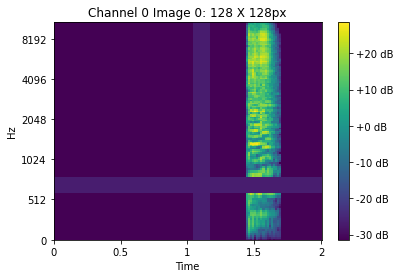

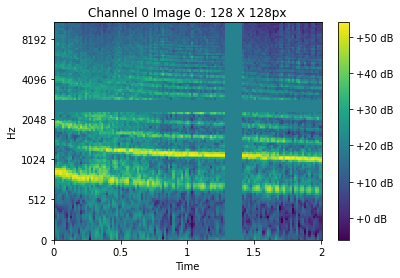

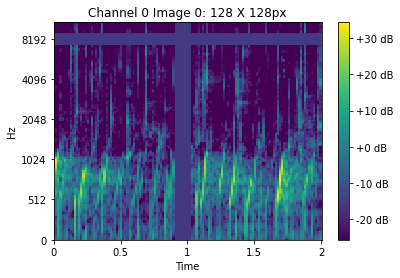

Fart
Screaming
Fill_(with_liquid)

Loading Stage 1 model - fold 4.

Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.062161,0.046113,0.548144,00:23
1,0.054263,0.040392,0.629429,00:23
2,0.049529,0.037604,0.660051,00:23
3,0.047174,0.036184,0.682768,00:22
4,0.045129,0.033412,0.703146,00:23
5,0.043337,0.032629,0.719849,00:22
6,0.042025,0.031482,0.732719,00:23
7,0.041044,0.031210,0.731151,00:22
8,0.040024,0.030623,0.738963,00:23
9,0.039294,0.029868,0.745498,00:22


Saving model...

Curated Train Set - Fold 5/5


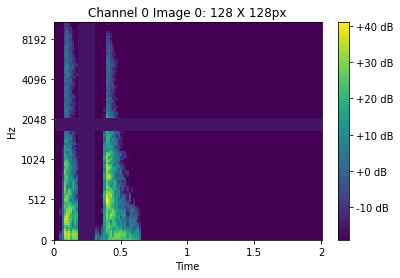

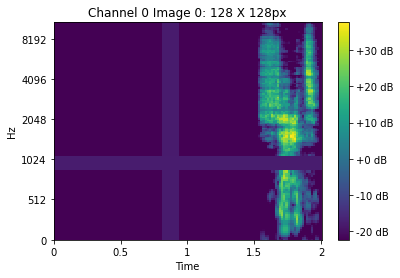

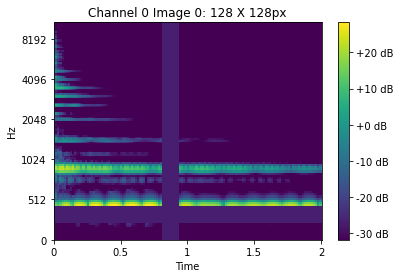

Knock
Yell
Chink_and_clink

Loading Stage 1 model - fold 5.

Training on Curated Set:


epoch,train_loss,valid_loss,lwlrap,time
0,0.062278,0.047624,0.526126,00:23
1,0.054114,0.041712,0.601632,00:23
2,0.049553,0.038286,0.637393,00:22
3,0.046870,0.036945,0.671290,00:23
4,0.045652,0.035216,0.688421,00:22
5,0.043571,0.033831,0.700782,00:22
6,0.042041,0.033036,0.710933,00:23
7,0.040826,0.032054,0.713633,00:22
8,0.039862,0.030722,0.741304,00:23
9,0.039167,0.030844,0.739668,00:22


Saving model...


In [35]:
## K-Folds training loop

# Use Sci-Kit learn splitter to provide index splits

df = df_curated

for fold, (train_idx, valid_idx) in enumerate(kf.split(df)):
    print(f'\nCurated Train Set - Fold {fold+1}/{n_splits}')

    def get_x(r): return r['fname']
    def get_y(r): return r['labels'].split(',') # split labels on ','

    dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                       splitter=IndexSplitter(valid_idx), # split using df index
                       get_x=get_x,
                       get_y=get_y,
                       item_tfms = item_tfms,
                       batch_tfms = batch_tfms # including RatioResize(256)
                      )

    dls = dblock.dataloaders(df, bs=64)

    dls.show_batch(max_n=3)

    print(f'\nLoading Stage 1 model - fold {fold+1}.')
    
    model = xresnet50(pretrained=False, act_cls=Mish, sa=True, c_in=1, n_out=80) #create custom xresnet: 1 input channel,  80 output nodes, self-attention, Mish activation function
    model = convert_MP_to_blurMP(model, nn.MaxPool2d) # convert MaxPool2D layers to MaxBlurPool
    learn = Learner(dls, model=model, loss_func=BCEWithLogitsLossFlat(),  opt_func=ranger, metrics=[lwlrap]) # pass custom model to Learner, no mixup for noisy set as fewer epochs
    learn.load(f'stage-1_noisy_fold-{fold+1}_sota2')
    
    learn.dls = dls
    learn.add_cb(MixUp()) # add mixup callback
    
    print('\nTraining on Curated Set:')
    learn.fit_flat_cos(50, 3e-4)

    print('Saving model...')
    learn.save(f'stage-2_curated_fold-{fold+1}_sota2')
    
    

## Stage 3 - Get Test-Set Predictions By Ensembling Predictions From All 5 Stage 2 Models

In [36]:
predictions = None

# grab test files from submission csv
df_fnames = pd.read_csv('../data/sample_submission.csv')
fnames = df_fnames.fname
df_fnames = '../data/test/' + df_fnames.fname
print(df_fnames[:5])

# get predictions
for fold in range(n_splits):
    stage = 2
    print(f'Getting predictions from stage {stage} fold {fold+1} model.')
#     model = xresnet50(pretrained=False, act_cls=Mish, sa=True, c_in=1, n_out=80) #create custom xresnet: 1 input channel,  80 output nodes, self-attention, Mish activation function
#     model = convert_MP_to_blurMP(model, nn.MaxPool2d) # convert MaxPool2D layers to MaxBlurPool
#     learn = Learner(dls, model=model, loss_func=BCEWithLogitsLossFlat(),  opt_func=ranger, metrics=[lwlrap]) # pass custom model
    learn = learn.load(f'stage-2_curated_fold-{fold+1}_sota2')

    dl = learn.dls.test_dl(df_fnames)
    
    # predict using tta    
    preds, targs = learn.tta(dl=dl)
    preds = preds.cpu().numpy()
    
    if fold == 0:
        predictions = preds
    else:
        predictions += preds


# Average predictions
predictions /= n_splits

# Create Submission DataFrame    
df_sub = pd.DataFrame(predictions)
df_sub.columns = learn.dls.vocab
df_sub.insert(0, "fname", 0)
df_sub.fname = fnames
df_sub.head()

0    ../data/test/4260ebea.wav
1    ../data/test/426eb1e0.wav
2    ../data/test/428d70bb.wav
3    ../data/test/4292b1c9.wav
4    ../data/test/429c5071.wav
Name: fname, dtype: object
Getting predictions from stage 2 fold 1 model.


Getting predictions from stage 2 fold 2 model.


Getting predictions from stage 2 fold 3 model.


Getting predictions from stage 2 fold 4 model.


Getting predictions from stage 2 fold 5 model.


,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0.000061,0.000104,0.000137,0.000128,0.001491,0.000042,0.000069,0.018890,0.000347,...,0.001809,0.000019,0.029009,0.000020,0.169202,0.000011,0.000244,0.003366,0.000193,0.001686
1,426eb1e0.wav,0.000015,0.000010,0.000085,0.898720,0.000217,0.000245,0.000140,0.001390,0.000186,...,0.000770,0.000178,0.000485,0.000795,0.000049,0.000585,0.000133,0.000017,0.000033,0.000086
2,428d70bb.wav,0.000018,0.000023,0.000194,0.000043,0.000095,0.000302,0.000132,0.000046,0.000123,...,0.000062,0.000178,0.000060,0.000099,0.000040,0.000254,0.014545,0.000395,0.000121,0.000204
3,4292b1c9.wav,0.000834,0.001137,0.000284,0.000262,0.000232,0.000047,0.000248,0.000084,0.000309,...,0.000621,0.000064,0.001757,0.000019,0.000417,0.000005,0.000084,0.000020,0.001609,0.000458
4,429c5071.wav,0.006854,0.000236,0.000785,0.000203,0.004170,0.072727,0.002440,0.002069,0.003006,...,0.001171,0.002079,0.000135,0.021521,0.000517,0.016996,0.002107,0.008808,0.000323,0.011652


In [37]:
df_sub.to_csv('submission-stage-2-5kfold.csv', index=False)

In [ ]:
learn.show_results()

## Kaggle Score

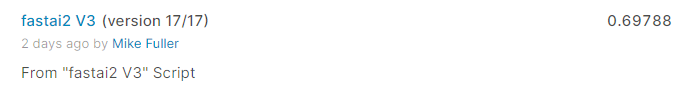

## References 

https://www.kaggle.com/c/freesound-audio-tagging-2019

https://github.com/rbracco/fastai2_audio

https://github.com/fastai/fastai2

https://github.com/fastai/fastbook

https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0

https://github.com/ebouteillon/freesound-audio-tagging-2019#Data-Augmentation

https://medium.com/@mnpinto/multi-label-audio-classification-7th-place-public-lb-solution-for-freesound-audio-tagging-2019-a7ccc0e0a02f

